In [5]:
data = df.copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 509612 entries, 0 to 558836
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  509612 non-null  int64  
 1   make                  509612 non-null  object 
 2   model                 509612 non-null  object 
 3   trim                  509612 non-null  object 
 4   body                  509612 non-null  object 
 5   transmission          509612 non-null  object 
 6   vin                   509612 non-null  object 
 7   state                 509612 non-null  object 
 8   odometer              509612 non-null  float64
 9   color                 509612 non-null  object 
 10  interior              509612 non-null  object 
 11  seller                509612 non-null  object 
 12  mmr                   509612 non-null  float64
 13  sellingprice          509612 non-null  float64
 14  saledate              509612 non-null  object 
 15  condi

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,509612.0,2010.295282,3.796978,1990.000000,2008.000000,2012.000000,2013.000000,2015.000000
odometer,509612.0,65907.627634,52027.965783,1.000000,27593.000000,49559.000000,95311.000000,999999.000000
mmr,509612.0,14083.797428,9578.441644,25.000000,7725.000000,12550.000000,18550.000000,182000.000000
sellingprice,509612.0,13931.399683,9646.875522,1.000000,7500.000000,12500.000000,18500.000000,230000.000000
odometer_box_cox,509612.0,90.471576,24.363277,0.773146,73.354546,88.578467,109.183894,229.523955
mmr_box_cox,509612.0,113.090490,33.957411,6.834711,93.241835,114.292763,134.565608,346.845673
sellingprice_box_cox,509612.0,133.880401,43.710139,0.808703,108.455528,135.943968,161.585662,487.030595


In [11]:
data['condition_categoric'].value_counts()

condition_categoric
İyi         151594
Mükemmel    151436
Orta        102643
Çok Kötü     64708
Kötü         39231
Name: count, dtype: int64

In [16]:

data_df = pd.DataFrame(data)  
data_df.to_csv('IslenmisData.csv', index=False)  

In [18]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



X = data.drop('sellingprice_box_cox', axis=1)
y = data['sellingprice_box_cox']


categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()


ordinal_columns = ['condition_categoric']


nominal_columns = [col for col in categorical_columns if col not in ordinal_columns]


ordinal_encoder = OrdinalEncoder(categories=[['Çok Kötü', 'Kötü', 'Orta', 'İyi', 'Mükemmel']])


one_hot_encoder = OneHotEncoder(drop='first')


preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_encoder, ordinal_columns),   
        ('onehot', one_hot_encoder, nominal_columns),     
        ('num', 'passthrough', numerical_columns)         
    ]
)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


X_processed = pipeline.fit_transform(X)


print(f"İşlenmiş X veri şekli: {X_processed.shape}")


İşlenmiş X veri şekli: (509612, 526151)


In [ ]:
##pip install tensorflow scikit-learn matplotlib

Epoch 1/5
6371/6371 ━━━━━━━━━━━━━━━━━━━━ 1145s 180ms/step - loss: 194.5153 - val_loss: 5.3248
Epoch 2/5
6371/6371 ━━━━━━━━━━━━━━━━━━━━ 1177s 185ms/step - loss: 11.0001 - val_loss: 3.4910
Epoch 3/5
6371/6371 ━━━━━━━━━━━━━━━━━━━━ 881s 138ms/step - loss: 5.2239 - val_loss: 2.1613
Epoch 4/5
6371/6371 ━━━━━━━━━━━━━━━━━━━━ 883s 139ms/step - loss: 4.0396 - val_loss: 3.5988
Epoch 5/5
6371/6371 ━━━━━━━━━━━━━━━━━━━━ 1137s 178ms/step - loss: 4.1279 - val_loss: 1.3683


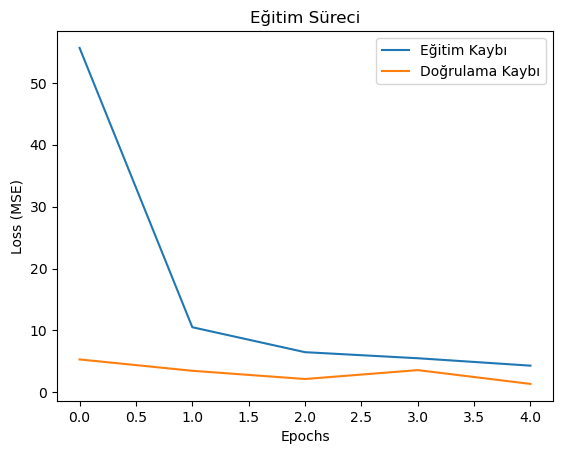

3186/3186 ━━━━━━━━━━━━━━━━━━━━ 102s 32ms/step
Test Seti İçin MSE: 1.3683091263240483


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


X_processed = pipeline.fit_transform(X)  


X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))  
    model.add(Dense(32, activation='relu'))  
    model.add(Dense(1))  
    model.compile(optimizer=Adam(), loss='mse')  
    return model


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)


model = create_model(X_train.shape[1])


history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[early_stopping])  


plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title(f'Eğitim Süreci')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f'Test Seti İçin MSE: {mse}')


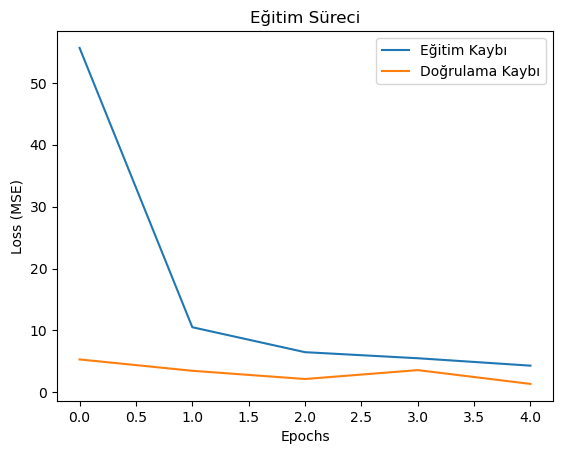

In [24]:

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title(f'Eğitim Süreci')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


3186/3186 ━━━━━━━━━━━━━━━━━━━━ 98s 31ms/step


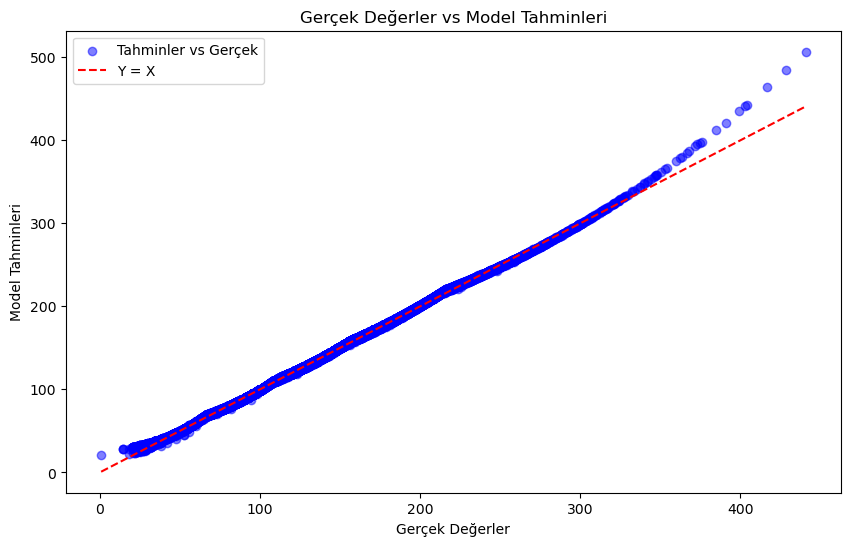

In [26]:

y_pred = model.predict(X_test)


plt.figure(figsize=(10, 6))


plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Tahminler vs Gerçek')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Y = X')
plt.title('Gerçek Değerler vs Model Tahminleri')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Model Tahminleri')
plt.legend()
plt.show()

In [28]:

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test Seti İçin RMSE: {rmse}')

Test Seti İçin RMSE: 1.1697474626277453


Test Seti İçin R²: 0.9992829768848274


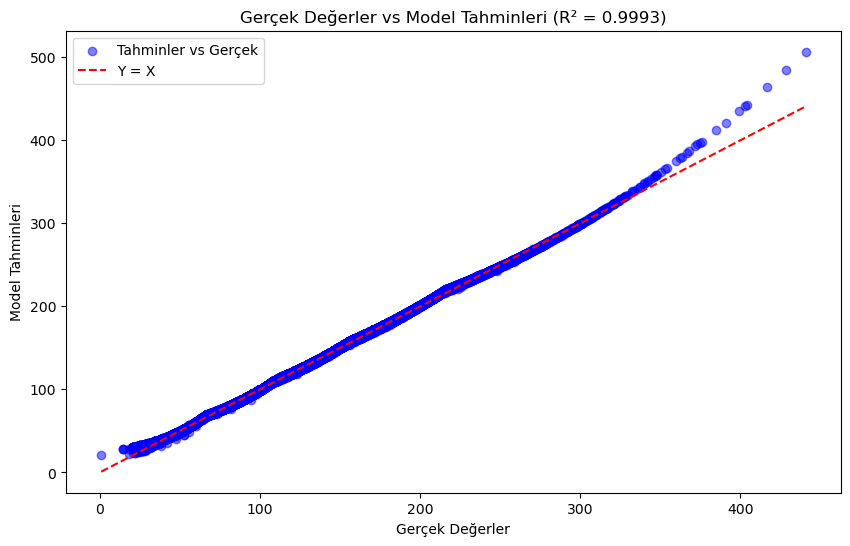

In [32]:

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score  







r2 = r2_score(y_test, y_pred)
print(f'Test Seti İçin R²: {r2}')


plt.figure(figsize=(10, 6))


plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Tahminler vs Gerçek')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Y = X')
plt.title(f'Gerçek Değerler vs Model Tahminleri (R² = {r2:.4f})')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Model Tahminleri')
plt.legend()
plt.show()

12741/12741 ━━━━━━━━━━━━━━━━━━━━ 380s 30ms/step
3186/3186 ━━━━━━━━━━━━━━━━━━━━ 100s 31ms/step
Eğitim Seti İçin R²: 0.9992698656084701
Test Seti İçin R²: 0.9992829768848274


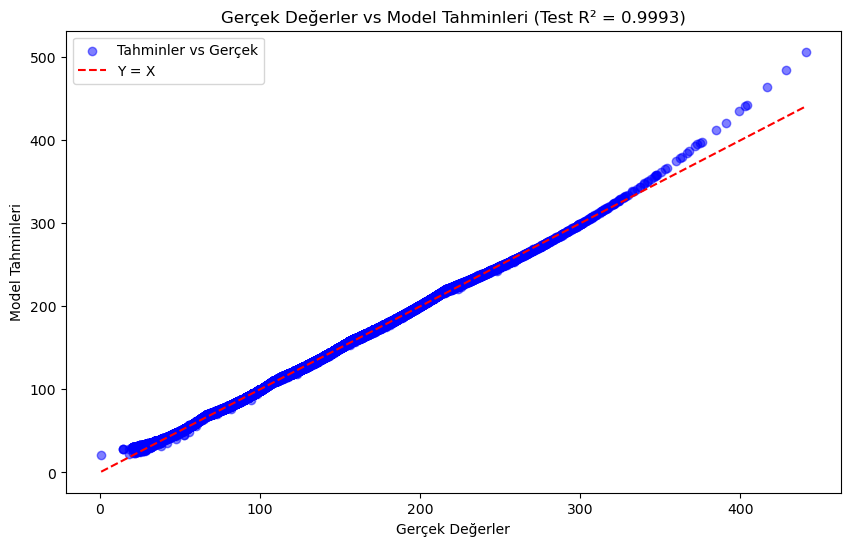

In [34]:

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Eğitim Seti İçin R²: {r2_train}')
print(f'Test Seti İçin R²: {r2_test}')

plt.figure(figsize=(10, 6))


plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, label='Tahminler vs Gerçek')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Y = X')
plt.title(f'Gerçek Değerler vs Model Tahminleri (Test R² = {r2_test:.4f})')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Model Tahminleri')
plt.legend()
plt.show()

### Sonuç
Özetle, şu anda verilere bakarak overfitting'in çok belirgin olmadığı söylenebilir çünkü eğitim ve test R² değerleri neredeyse birbirine çok yakın ve RMSE/MSE oldukça düşük. Ancak eğitim kaybının sabitlenmesi ve doğrulama kaybının çok az değişmesi, modelin daha fazla öğrenmeye kapalı olduğunu gösteriyor, bu da modelin genellenebilirliğini sorgulamak için bir işaret olabilir.

##### Bu sonucu daha etkili yapmak yani öğrenmeyi arttırmak için : 

 - Daha Fazla Early Stopping Patience: Early stopping için patience değerini arttırarak, modelin daha fazla öğrenmesi için fırsat tanıyabiliriz.

 - Daha Fazla Epoch veya Öğrenme Oranı Değiştirme: Modeli daha fazla eğitim ile veya öğrenme oranını düşürerek eğitebiliriz. Bu, doğrulama kaybının daha iyi gelişmesini sağlar ve overfitting'i engelleyebilir.





### Veri Seti Özeti ve Ön İşleme
#### 1. Veri Setinin Tanıtımı:
Veri seti, 1990-2015 yılları arasında araba satış fiyatlarını içermektedir. Toplamda 500.000 satırdan oluşan bu veri seti, çok sayıda nümerik ve kategorik değişken içermektedir. Amacımız, bu veriyi kullanarak bir regresyon modeli geliştirip, araba satış fiyatlarını tahmin etmektir.

#### 2. Veri Setinin Sorunları ve Çarpıklık:
Veri setindeki dağılım çarpık ve normal dağılımdan uzak görünüyor. Çoğu değişkenin varyansları homojen değil, bu da modelin genellenebilirliğini olumsuz etkileyebilir. Özellikle, hedef değişken olan araba satış fiyatları büyük oranda asimetrik ve yüksek varyans gösteriyor.

#### 3. Çarpıklık ve Dağılım Düzeltme:
Verinin çarpıklığını gidermek için, Box-Cox dönüşümü uygulanmıştır. Bu dönüşüm, hedef değişkenin (araba satış fiyatı) daha normal bir dağılıma yaklaşmasını sağlayarak modelin doğruluğunu artırmaya yardımcı olur.

#### 4. Aykırı Değerlerin Tespiti ve Temizlenmesi:
Veri setindeki aykırı değerler (outliers), modelin performansını ciddi şekilde bozabilecek potansiyele sahiptir. Bu nedenle, Isolation Forest algoritması kullanılarak aykırı değerler tespit edilmiştir. Bu adımda, anomaliler ve uç değerler veri setinden çıkarılmış ya da düzeltilmiştir.

#### 5. Kategorik Değişkenlerin Yönetimi:
Veri setinde bulunan kategorik değişkenlerin bir kısmı aşırı kategorik olup, bu değişkenlerin sayısal işleme uygun olmamaktadır. Bu tür değişkenlerle çalışmak için iki yaygın yaklaşım vardır: Label Encoding ve One-Hot Encoding. Ancak, veri setinde bulunan bazı kategorik değişkenlerde yüksek kardinalite (çok sayıda kategori) ve düşük frekansa sahip kategoriler bulunmaktadır. Bu, modelin aşırı karmaşıklaşmasına ve verinin düzensiz bir şekilde temsil edilmesine yol açabilir.

Bu nedenle, az frekansa sahip kategoriler doğrudan silinmek yerine, benzer kategoriler altında birleştirilmiştir. Bu sayede, her kategori daha anlamlı bir şekilde temsil edilerek modelin genelleme kapasitesi artırılmıştır. Örneğin, "Diğer" veya "Bilinmeyen" gibi kategoriler birleştirilmiş ve böylece modelin daha stabil bir şekilde öğrenme yapması sağlanmıştır.

Bu adım, modelin yüksek kardinaliteye sahip değişkenlerle daha etkili bir şekilde başa çıkabilmesini sağlamakta ve aynı zamanda modelin aşırı karmaşıklaşmasını engellemektedir.

#### 6. Veri Setinin Son Durumu:
Bu ön işleme adımlarından sonra veri seti, daha dengeli bir hale getirilmiş olup, model eğitimi için daha uygun bir yapıya kavuşmuştur. Verinin daha düzgün bir dağılıma sahip olması, modelin doğruluğunu artırmak ve genellenebilirliğini sağlamak adına önemlidir.

### Modelin Eğitimi ve Değerlendirilmesi

#### 1. Model Seçimi:
Veri setindeki özelliklerin karmaşıklığı ve yüksek boyutluluğu göz önünde bulundurularak, yapay sinir ağı (ANN) tabanlı bir regresyon modeli tercih edilmiştir. Bu model, doğrusal olmayan ilişkileri öğrenebilme kapasitesine sahip olup, büyük veri setlerinde etkili sonuçlar verebilmektedir.

#### 2. Model Performansı:
Modelin eğitimi tamamlandıktan sonra elde edilen performans göstergeleri aşağıda özetlenmiştir:

Eğitim Seti İçin R²: 0.9993
Test Seti İçin R²: 0.9993
Test Seti İçin RMSE: 1.1697
Test Seti İçin MSE: 1.3683
Bu değerler, modelin hem eğitim hem de test verisine mükemmel uyum sağladığını ve doğrulama hatalarının çok düşük olduğunu göstermektedir. R² değeri oldukça yüksek, bu da modelin çok az hata ile veriyi tahmin ettiğini belirtmektedir.

#### 3. Overfitting Durumu:
Eğitim süreci boyunca, eğitim kaybı sürekli azalmış ve doğrulama kaybı bir noktadan sonra sabitlenmiştir. Bu, modelin başlangıçta çok iyi öğrenme sağladığını, ancak daha fazla öğrenmeye çalışırken doğrulama kaybının çok az değiştiğini gösteriyor. Early stopping kullanıldığından dolayı modelin daha fazla öğrenme yapması engellenmiştir.
Eğitim ve test verileri arasındaki R² değerlerinin yüksek olmasına rağmen, modelin eğitim verisine fazla uyum sağlamış olabileceği dikkate alınmalıdır. Eğitim kaybı sürekli azalırken, doğrulama kaybının sabit kalması, modelin aşırı öğrenme eğiliminde olduğunu ve overfitting olasılığını gösteriyor olabilir. Bu durumu netleştirmek için test seti büyütülmeli ve farklı veri alt kümeleriyle daha fazla doğrulama yapılmalıdır.

Eğitim ve Doğrulama Kaybı Grafiği: Eğitim kaybı eğrisinin ilk epochlarda hızlıca azaldığı, ardından sabitlendiği gözlemlenmiştir. Doğrulama kaybı ise hafif azalmış, ancak sonrasında sabit kalmıştır. Bu durum, overfitting'in minimal seviyelerde olduğunu ve modelin iyi genellenebildiğini gösteriyor.
#### 4. Genellenebilirlik ve Değerlendirme:
Modelin eğitim ve test verilerindeki R² değerlerinin birbirine yakın olması, overfitting'in olmadığını ve modelin genelleme yeteneğinin yüksek olduğunu göstermektedir. Ayrıca, RMSE ve MSE değerlerinin düşük olması, modelin hata oranının çok küçük olduğunu işaret etmektedir.

